In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import networkx as nx
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from collections import Counter
import math

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [25, 12]

In [4]:
data=pd.read_csv('/content/drive/My Drive/train_data.csv')
data.head(3)

,xid,age,followings_list
0,27584085,24.58,"10305765,5932378,7958456,28485643,29048886,306..."
1,29710390,28.85,"31099779,18181979,10154448,10571680,5447425,11..."
2,17609744,22.18,"14763433,15686748,7974801,26605299,26784299,30..."


In [5]:
#setting column data types and adding a column that counts how many accounts the user follows
data['xid']=data['xid'].astype('str')
data['followings_list']=data['followings_list'].map(lambda x: list(x.split(',')))
data['followings_count']=data['followings_list'].map(lambda x: len(x))
data.head(3)

,xid,age,followings_list,followings_count
0,27584085,24.58,"[10305765, 5932378, 7958456, 28485643, 2904888...",88
1,29710390,28.85,"[31099779, 18181979, 10154448, 10571680, 54474...",112
2,17609744,22.18,"[14763433, 15686748, 7974801, 26605299, 267842...",110


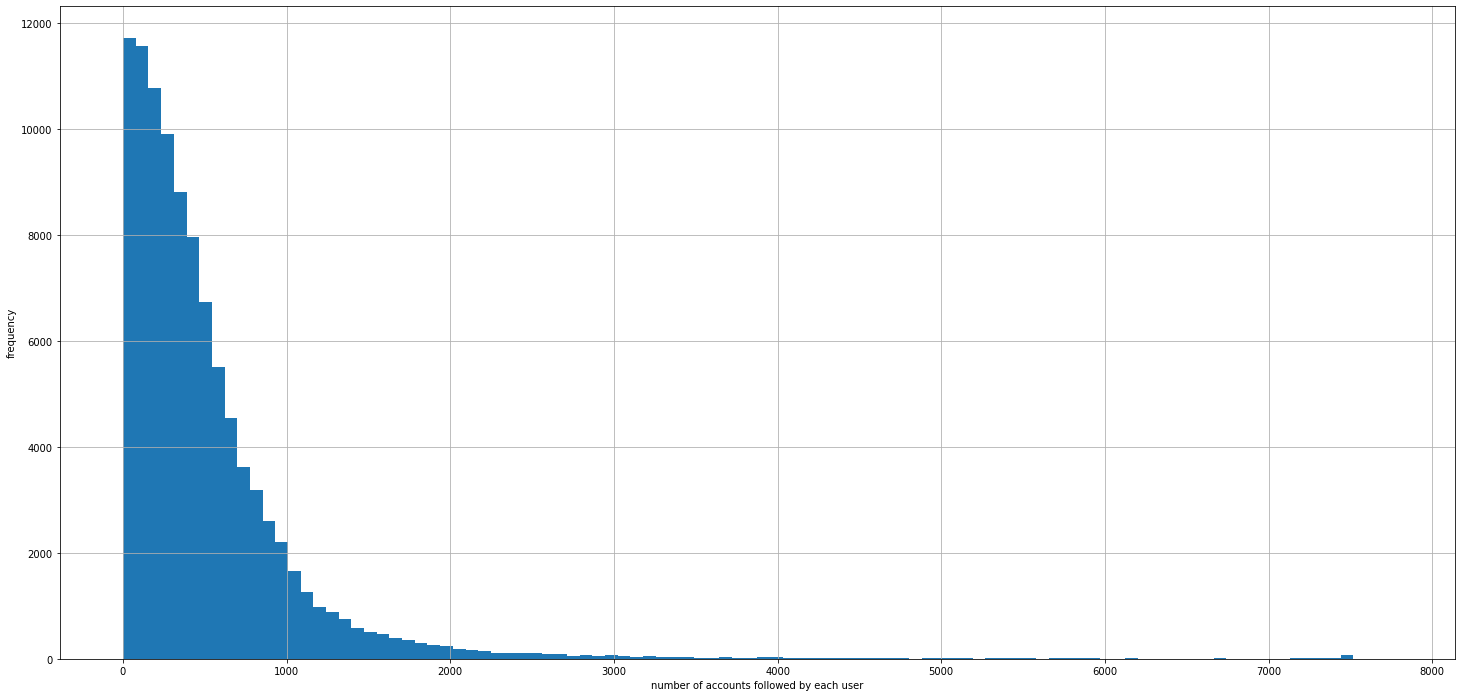

In [6]:
plt.ylabel('frequency')
plt.xlabel('number of accounts followed by each user')
data['followings_count'].hist(bins=100)

In [7]:
#we can see there isn't much of a correlation between a user's age and the number of accounts he/she follows
np.corrcoef(data['followings_count'], data['age'])[0,1]

-0.04971060610787327

In [8]:
#when we model age against followings_count using simple linear regression,
#we can see the R-square value is pretty low for all of our 5 folds
regr = linear_model.LinearRegression()
cross_val_score(regr, data[['followings_count']], data[['age']], cv=5, scoring='r2')

array([0.00197664, 0.00285071, 0.00310638, 0.00263506, 0.00144312])

Coefficients: 
 [-0.00080732]
Mean squared error: 83.6405
Coefficient of determination: 0.0014


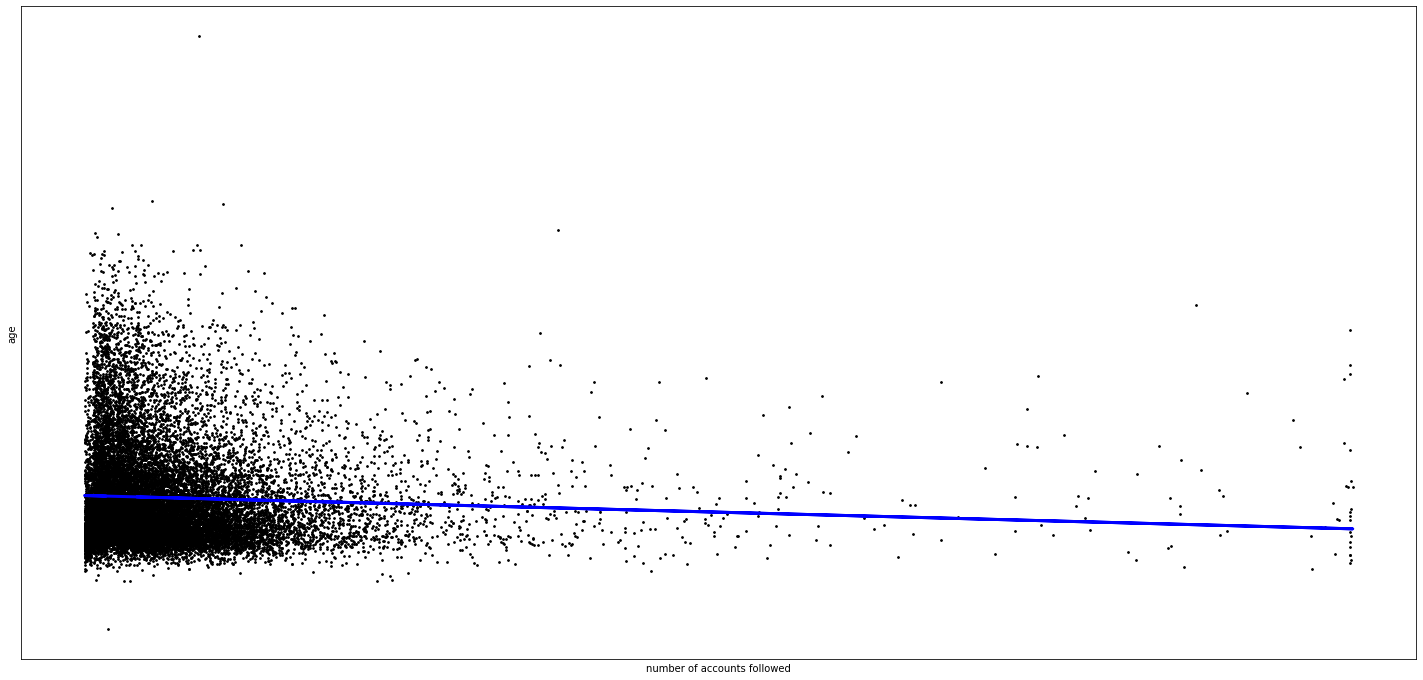

In [9]:
# Use only one feature
data_X = data[['followings_count']]
data_y = data['age']

# Split the data into training/testing sets
data_X_train = data_X[:-20000]
data_X_test = data_X[-20000:]

# Split the targets into training/testing sets
data_y_train = data_y[:-20000]
data_y_test = data_y[-20000:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(data_X_train, data_y_train)

# Make predictions using the testing set
data_y_pred = regr.predict(data_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.4f'
      % mean_squared_error(data_y_test, data_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.4f'
      % r2_score(data_y_test, data_y_pred))

# Plot outputs
plt.scatter(data_X_test, data_y_test,  color='black', s=3)
plt.plot(data_X_test, data_y_pred, color='blue', linewidth=3)

plt.xlabel('number of accounts followed')
plt.ylabel('age')
plt.xticks(())
plt.yticks(())

plt.show()

We can clearly see that the number of accounts that a user follows has almost no association with the user's age. 


---

This indicates we might need to use age information from each user's connections to create more informative features.

We define an outgoing connection as someone you follow, while an incoming connection is someone who follows you.





In [10]:
age_dict=data[['xid','age']].set_index('xid').T.to_dict('list')
#dictionary that has user ID as key and user age as value

In [11]:
graph_dict=data[['xid','followings_list']].set_index('xid').T.to_dict('list')
##dictionary that has user ID as key and followings_list as value

In [12]:
data['outgoing_connections_in_dataset']=[np.nan]*100000
data['number_of_outgoing_connections_in_dataset']=[np.nan]*100000
data['average_outgoing_connection_age']=[np.nan]*100000

In [13]:
#This cell fills out the three columns defined above, outgoing_connections_in_dataset, number_of_outgoing_connections_in_dataset, average_outgoing_connection_age
for i in range(100000):

  average_sum=0 
  index=0
  graph_connections=[]
  
  for friend in data.iloc[i,2]:
  
    try:
      average_sum=average_sum+age_dict[friend][0]
      index=index+1
      graph_connections.append(friend)
    except KeyError:
      pass
  
  if index != 0:
    data.loc[[i], 'outgoing_connections_in_dataset'] = pd.Series([graph_connections], index = [i])
    data.iloc[i,5]=index
    data.iloc[i,6]=average_sum/index


In [14]:
data.head()

,xid,age,followings_list,followings_count,outgoing_connections_in_dataset,number_of_outgoing_connections_in_dataset,average_outgoing_connection_age
0,27584085,24.58,"[10305765, 5932378, 7958456, 28485643, 2904888...",88,NaN,NaN,NaN
1,29710390,28.85,"[31099779, 18181979, 10154448, 10571680, 54474...",112,NaN,NaN,NaN
2,17609744,22.18,"[14763433, 15686748, 7974801, 26605299, 267842...",110,NaN,NaN,NaN
3,25298187,18.82,"[7737451, 9671271, 10499848, 7695130, 30913705...",882,"[23836550, 27622519, 32182702, 23594417, 25299...",5.0,23.472
4,3161582,29.19,"[4640603, 10885113, 17076642, 16953146, 317075...",261,NaN,NaN,NaN


In the dataframe above, we have added columns that show the names and quantity of the accounts that a user follows which are present in the dataset. There is also a column for the average age of these accounts.

In [15]:
data['number_of_outgoing_connections_in_dataset'].max()
#data['number_of_connections_in_dataset'] shows how many of the accounts that one follows are also present in the dataset.
#this cell shows that 23 is the maximum

23.0

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'frequency')

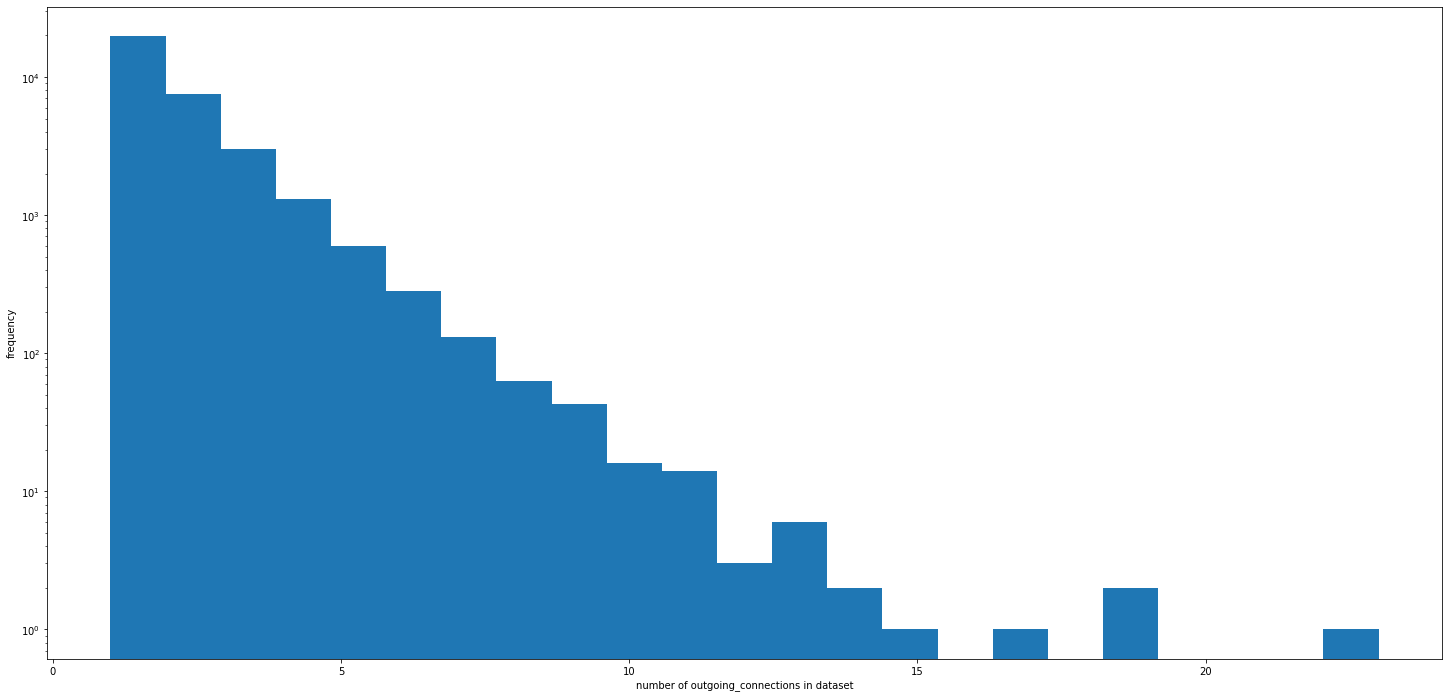

In [16]:
plt.hist(data['number_of_outgoing_connections_in_dataset'], log=True, bins=23) 
plt.xlabel('number of outgoing_connections in dataset')
plt.ylabel('frequency')

In the cell below, we create columns that show how similar two accounts are based on the accounts that they follow. This is calculated using cosine similarity.

We also added columns that calculate the average connection age weighted by the similarity between the given account and each of its connections.

In [17]:
data['outgoing_connections_similarity']=np.nan
data['outgoing_similarity_weighted_age']=np.nan
data['average_incoming_connection_age']=np.nan
data['incoming_connections_similarity']=np.nan
data['incoming_similarity_weighted_age']=np.nan
data['overall_similarity_weighted_age']=np.nan
data['overall_average_age']=np.nan

In [18]:
def counter_cosine_similarity(lis1, lis2):
    c1=Counter(lis1)
    c2=Counter(lis2)
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)

In [19]:
#example of the similarity function
counter_cosine_similarity(['A', 'B', 'C'], ['B', 'C', 'D', 'E'])

0.5773502691896258

In [20]:
#example of the similarity function
counter_cosine_similarity(['A', 'B', 'C'], ['D', 'E'])

0.0

In [27]:
graph_data=data.loc[data['outgoing_connections_in_dataset'].notna()]
graph_data.reset_index(inplace=True)

#this code fills out the columns for 'incoming_connections_similarity' and 'outgoing_connections_similarity'
for i in graph_data['index']:
  sim_list=[]

  friend_num=0
  for friend in data.iloc[i,4]:
    score=counter_cosine_similarity(graph_dict[data.iloc[i,0]][0], graph_dict[friend][0])
    sim_list.extend([[friend, score, age_dict[friend][0]]])
    
    friend_index = data.loc[data['xid']==friend].index[0]
    read_in = data.iloc[friend_index, 9]
    pim_list=read_in
    
    if np.isnan(read_in).sum()>0:
      pim_list = []
    
    pim_list.extend([[score, age_dict[data.iloc[i,0]][0]]])
    data.loc[[friend_index], 'incoming_connections_similarity'] = pd.Series([pim_list], index = [friend_index])

  data.loc[[i], 'outgoing_connections_similarity'] = pd.Series([sim_list], index = [i])

In [29]:
#calculating outgoing_similarity_weighted_age
for i in graph_data['index']:

  weight_sum=0
  for item in data.iloc[i, 7]:
    weight_sum = weight_sum + item[1]
  
  if weight_sum == 0: #the similarity scores are zero so we won't predict anything
    continue
  
  weighted_age = 0
  for item in data.iloc[i, 7]:
    weighted_age = weighted_age + item[1]*item[2]/weight_sum
  
  data.iloc[i,8] = weighted_age

In [30]:
inco_data=data.loc[data['incoming_connections_similarity'].notna()]
inco_data.reset_index(inplace=True)

#calculating incoming_similarity_weighted_age
for i in inco_data['index']:

  weight_sum=0
  for item in data.iloc[i, 10]:
    weight_sum = weight_sum + item[0]
  
  if weight_sum == 0: #the similarity scores are zero so we won't predict anything
    continue
  
  weighted_age = 0
  for item in data.iloc[i, 10]:
    weighted_age = weighted_age + item[0]*item[1]/weight_sum
  
  data.iloc[i,11] = weighted_age

#calculating average_incoming_connection_age
for i in inco_data['index']:
  age_sum=0
  for item in data.iloc[i, 10]:
    age_sum = age_sum + item[1]

  data.iloc[i,9] = age_sum/len(data.iloc[i, 10])

In [32]:
combined_data=data.loc[(data['incoming_connections_similarity'].notna()) | (data['outgoing_connections_similarity'].notna())]
combined_data.reset_index(inplace=True)

#calculating overall similarity weighted age using both incoming and outgoing connections
for i in combined_data['index']:

  weight_sum=0
  if type(data.iloc[i,7]) != float:
    for item in data.iloc[i, 7]:
      weight_sum = weight_sum + item[1]
  
  if type(data.iloc[i,10]) != float:
    for item in data.iloc[i, 10]:
      weight_sum = weight_sum + item[0]
  
  if weight_sum == 0: #the similarity scores are zero so we don't predict
    continue
  
  weighted_age = 0
  if type(data.iloc[i,7]) != float:
    for item in data.iloc[i, 7]:
      weighted_age = weighted_age + item[1]*item[2]/weight_sum

  if type(data.iloc[i,10]) != float:
    for item in data.iloc[i, 10]:
      weighted_age = weighted_age + item[0]*item[1]/weight_sum
  
  data.iloc[i,12] = weighted_age

for i in combined_data['index']:
  overall_age = 0
  weight_sum1 = 0
  weight_sum2 = 0

  if type(data.iloc[i,7]) != float:
    for item in data.iloc[i, 7]:
      overall_age = overall_age + item[2]
    weight_sum1 = len(data.iloc[i,7])

  if type(data.iloc[i,10]) != float:
    for item in data.iloc[i, 10]:
      overall_age = overall_age + item[1]
    weight_sum2 = len(data.iloc[i,10])

  data.iloc[i,13] = overall_age/(weight_sum1+weight_sum2)


In [33]:
data.head()

,xid,age,followings_list,followings_count,outgoing_connections_in_dataset,number_of_outgoing_connections_in_dataset,average_outgoing_connection_age,outgoing_connections_similarity,outgoing_similarity_weighted_age,average_incoming_connection_age,incoming_connections_similarity,incoming_similarity_weighted_age,overall_similarity_weighted_age,overall_average_age
0,27584085,24.58,"[10305765, 5932378, 7958456, 28485643, 2904888...",88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29710390,28.85,"[31099779, 18181979, 10154448, 10571680, 54474...",112,NaN,NaN,NaN,NaN,NaN,15.78,"[[0.0, 15.78]]",NaN,NaN,15.780
2,17609744,22.18,"[14763433, 15686748, 7974801, 26605299, 267842...",110,NaN,NaN,NaN,NaN,NaN,22.69,"[[0.0036153894822583475, 22.69]]",22.69,22.690000,22.690
3,25298187,18.82,"[7737451, 9671271, 10499848, 7695130, 30913705...",882,"[23836550, 27622519, 32182702, 23594417, 25299...",5.0,23.472,"[[23836550, 0.0, 19.06], [27622519, 0.11008072...",28.845803,44.73,"[[0.1884486385365329, 44.73]]",44.73,33.528579,27.015
4,3161582,29.19,"[4640603, 10885113, 17076642, 16953146, 317075...",261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Different regression settings**


We will do multiple linear regression with account user age as the dependent variable and the following as the independent variables:



1.   outgoing_similarity_weighted_age
2.   incoming_similarity_weighted_age and outgoing_similarity_weighted_age
3.   average_incoming_connection_age and average_outgoing_connection_age
4.   all of the above options together





Regression 1

In [38]:
reg1=data.loc[data['outgoing_similarity_weighted_age'].notna()]
reg1.reset_index(inplace=True)
reg1.shape

(30284, 15)

The cell above shows that this simple linear regression model can be used for 30% of the observations.

In [39]:
regr = linear_model.LinearRegression()
cross_val_score(regr, reg1[['outgoing_similarity_weighted_age']], reg1[['age']], cv=5, scoring='r2')

array([0.21839746, 0.17817079, 0.18558302, 0.17473779, 0.20493817])

Coefficients: 
 [0.48867043]
Mean squared error: 54.1161
Coefficient of determination: 0.2057


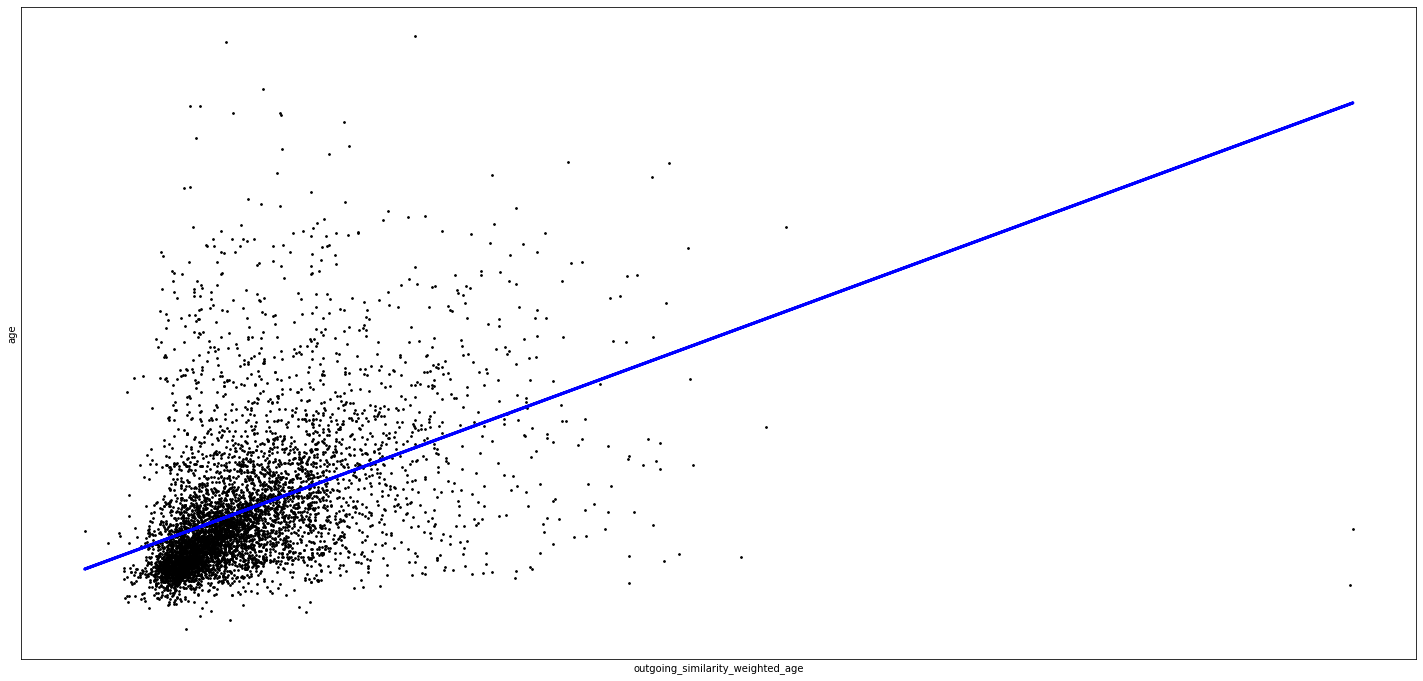

In [41]:
# Use only one feature
data_X = reg1[['outgoing_similarity_weighted_age']]
data_y = reg1['age']

# Split the data into training/testing sets
data_X_train = data_X[:-6000]
data_X_test = data_X[-6000:]

# Split the targets into training/testing sets
data_y_train = data_y[:-6000]
data_y_test = data_y[-6000:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(data_X_train, data_y_train)

# Make predictions using the testing set
data_y_pred = regr.predict(data_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.4f'
      % mean_squared_error(data_y_test, data_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.4f'
      % r2_score(data_y_test, data_y_pred))

# Plot outputs
plt.scatter(data_X_test, data_y_test,  color='black', s=3)
plt.plot(data_X_test, data_y_pred, color='blue', linewidth=3)

plt.xlabel('outgoing_similarity_weighted_age')
plt.ylabel('age')
plt.xticks(())
plt.yticks(())

plt.show()

Regression 2

In [42]:
reg2=data.loc[(data['incoming_similarity_weighted_age'].notna()) & (data['outgoing_similarity_weighted_age'].notna())]
reg2.reset_index(inplace=True)
reg2.shape

(22218, 15)

The cell above shows that this model can only be used for around 22% of the dataset.

In [43]:
regr = linear_model.LinearRegression()
cross_val_score(regr, reg2[['incoming_similarity_weighted_age', 'outgoing_similarity_weighted_age']], reg2[['age']], cv=5, scoring='r2')

array([0.24273938, 0.18466043, 0.21760834, 0.19736888, 0.21933461])

### Regression 3

In [44]:
reg3=data.loc[(data['average_outgoing_connection_age'].notna()) & (data['average_incoming_connection_age'].notna())]
reg3.reset_index(inplace=True)
reg3.shape

(23012, 15)

The cell above shows that this model can only be used for around 23% of the dataset.

In [45]:
regr = linear_model.LinearRegression()
cross_val_score(regr, reg3[['average_outgoing_connection_age', 'average_incoming_connection_age']], reg3[['age']], cv=5, scoring='r2')

array([0.25231697, 0.19147752, 0.21395775, 0.19721735, 0.23289754])

Regression 4

In [46]:
reg4=data.loc[(data['incoming_similarity_weighted_age'].notna()) & (data['outgoing_similarity_weighted_age'].notna()) & (data['average_incoming_connection_age'].notna()) & (data['average_outgoing_connection_age'].notna())]
reg4.reset_index(inplace=True)
reg4.shape

(22218, 15)

The cell above shows that this model can only be used for around 22% of the dataset.

In [47]:
regr = linear_model.LinearRegression()
cross_val_score(regr, reg4[['average_outgoing_connection_age', 'average_incoming_connection_age', 'outgoing_similarity_weighted_age', 'incoming_similarity_weighted_age']], reg4[['age']], cv=5, scoring='r2')

array([0.25019433, 0.1918334 , 0.22009548, 0.19542052, 0.22860872])

All four models have an R-squared value of between 0.20 and 0.25.

This isn't really ideal but it can be taken as a suggestion that more data for every user is needed for better prediction.

### Prediction
Given that all four of the models performed similarly, we will use regression model 1 since it's the simplest. Our objective is to predict the ages of the users in test_data.csv

In [48]:
test_data=pd.read_csv('/content/drive/My Drive/test_data.csv')
test_data.insert(1, 'inferred_age', np.nan)
test_data.head()

,xid,inferred_age,followings_list
0,7790143,NaN,"30293256,3371184,30262536,14176489,4445389,276..."
1,16987073,NaN,"17245494,15191225,18411221,18621565,21358140,1..."
2,13330820,NaN,"11013835,27416779,11310783,8400504,22472228,65..."
3,30526124,NaN,"20710115,20635736,30869594,20131491,32460237,1..."
4,31168989,NaN,"31001470,30798465,14516985,31704893,28048410,2..."


Now that the test data looks like the training data, we will have to repeat all the feature engineering steps we did for the training data. At the end, we will use regression model 1 to predict the age for each user.

In [49]:
test_data['xid']=test_data['xid'].astype('str')
test_data['followings_list']=test_data['followings_list'].map(lambda x: list(x.split(',')))
test_data['followings_count']=test_data['followings_list'].map(lambda x: len(x))

test_data['outgoing_connections_in_dataset']=[np.nan]*10000
test_data['number_of_outgoing_connections_in_dataset']=[np.nan]*10000
test_data['average_outgoing_connection_age']=[np.nan]*10000

for i in range(10000):

  average_sum=0 
  index=0
  graph_connections=[]
  
  for friend in test_data.iloc[i,2]:
  
    try:
      average_sum=average_sum+age_dict[friend][0]
      index=index+1
      graph_connections.append(friend)
    except KeyError:
      pass
  
  if index != 0:
    test_data.loc[[i], 'outgoing_connections_in_dataset'] = pd.Series([graph_connections], index = [i])
    test_data.iloc[i,5]=index
    test_data.iloc[i,6]=average_sum/index

test_data['outgoing_connections_similarity']=np.nan
test_data['outgoing_similarity_weighted_age']=np.nan
test_data['average_incoming_connection_age']=np.nan
test_data['incoming_connections_similarity']=np.nan
test_data['incoming_similarity_weighted_age']=np.nan
test_data['overall_similarity_weighted_age']=np.nan
test_data['overall_average_age']=np.nan


In [50]:
test_graph_dict=test_data[['xid','followings_list']].set_index('xid').T.to_dict('list')

In [52]:
graph_test_data=test_data.loc[test_data['outgoing_connections_in_dataset'].notna()]
graph_test_data.reset_index(inplace=True)

for i in graph_test_data['index']:
  sim_list=[]

  friend_num=0
  for friend in test_data.iloc[i,4]:
    score=counter_cosine_similarity(test_graph_dict[test_data.iloc[i,0]][0], graph_dict[friend][0])
    sim_list.extend([[friend, score, age_dict[friend][0]]])
    
  test_data.loc[[i], 'outgoing_connections_similarity'] = pd.Series([sim_list], index = [i])

#calculating outgoing_similarity_weighted_age
for i in graph_test_data['index']:

  weight_sum=0
  for item in test_data.iloc[i, 7]:
    weight_sum = weight_sum + item[1]
  
  if weight_sum == 0: #the similarity scores are zero so we won't predict anything
    continue
  
  weighted_age = 0
  for item in test_data.iloc[i, 7]:
    weighted_age = weighted_age + item[1]*item[2]/weight_sum
  
  test_data.iloc[i,8] = weighted_age

In [57]:
test_reg1=test_data.loc[test_data['outgoing_similarity_weighted_age'].notna()]
test_reg1.reset_index(inplace=True)
test_reg1.shape

(2953, 15)

The cell above demonstrates that we will be able to apply our regression model to around 30% of the test dataset.


---

In the next cell, we will use the regression model to predict the target variable, age.

In [61]:
reg1=data.loc[data['outgoing_similarity_weighted_age'].notna()]
reg1.reset_index(inplace=True)

# Use only one feature
data_X = reg1[['outgoing_similarity_weighted_age']]
data_y = reg1['age']

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(data_X, data_y)

# Make predictions using the testing set
data_y_pred = regr.predict(data_X)

# The intercept
print('Intercept: \n', regr.intercept_)
# The coefficients
print('Coefficient: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.4f'
      % mean_squared_error(data_y, data_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.4f'
      % r2_score(data_y, data_y_pred))

test_reg1['inferred_age'] = regr.predict(test_reg1[['outgoing_similarity_weighted_age']])


Intercept: 
 12.711092550416323
Coefficient: 
 [0.4926956]
Mean squared error: 58.5067
Coefficient of determination: 0.1927


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [83]:
for i in test_reg1['index']:
  test_data.iloc[i, 1] = float(test_reg1.loc[test_reg1['index']==i, 'inferred_age'])

In [86]:
test_data['inferred_age'].head()

0          NaN
1    21.885085
2          NaN
3    21.418458
4    37.050255
Name: inferred_age, dtype: float64

In [93]:
test_data[['xid', 'inferred_age']].to_csv('/content/drive/My Drive/inferred.csv', index=False, na_rep=np.nan)



---



---



# Graphing the data
Since this data comes from a social media network, it is quite suitable for representation as a graph. While a graph representation isn't really relevant for the assigned task of predicting ages for users, it can be useful for other kinds of analyses. 

In [90]:
graph_data['number_of_outgoing_connections_in_dataset'].sum()
#the number of edges and the number of times we will need to calculate the edge weight

56099.0

In [91]:
graph_data.head(1)

,index,xid,age,followings_list,followings_count,outgoing_connections_in_dataset,number_of_outgoing_connections_in_dataset,average_outgoing_connection_age,outgoing_connections_similarity,outgoing_similarity_weighted_age,average_incoming_connection_age,incoming_connections_similarity,incoming_similarity_weighted_age,overall_similarity_weighted_age,overall_average_age
0,3,25298187,18.82,"[7737451, 9671271, 10499848, 7695130, 30913705...",882,"[23836550, 27622519, 32182702, 23594417, 25299...",5.0,23.472,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
edge_list=[]
for i in range(graph_data.shape[0]):

  for friend in graph_data.iloc[i,5]:
    score=counter_cosine_similarity(graph_dict[graph_data.iloc[i,1]][0], graph_dict[friend][0])
    edge_list.extend([[graph_data.iloc[i,1], friend, score]])

edge_list_df=pd.DataFrame(edge_list)
edge_list_df.columns=['node_1', 'node_2', 'edge_weight']
edge_list_df.head()
#edge_list_df lists all the edges and their weights

,node_1,node_2,edge_weight
0,25298187,23836550,0.000000
1,25298187,27622519,0.110081
2,25298187,32182702,0.037951
3,25298187,23594417,0.114297
4,25298187,25299070,0.188449


In our network graph, each node represents a user account.

If user A follows user B, then node A will have a directed edge towards node B.

This graph will not include isolated nodes. Isolated nodes include accounts that don't follow anyone but also those accounts that follow users who are not in our dataset.

Each node will have age as an attribute.

The edge weight will be equal to the cosine similarity between the followings_list of node A and the followings_list of node B. In simple terms, we will compare how similar are the accounts the user A follows as compared to the accounts that user B follows.

In [94]:
#we create a network from edge_list_df
G=nx.convert_matrix.from_pandas_edgelist(edge_list_df, 'node_1', 'node_2', 'edge_weight', create_using=nx.MultiDiGraph())

In [95]:
#add the age attribute to each node
nx.set_node_attributes(G, age_dict, 'age')

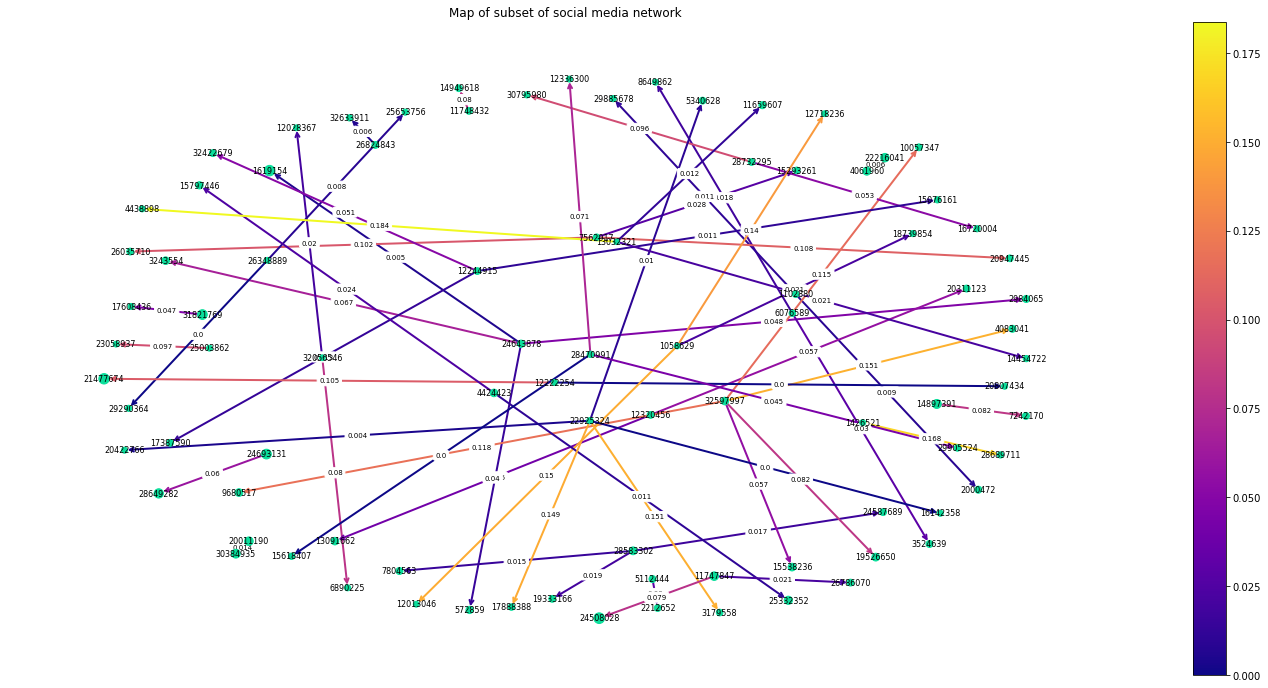

In [96]:
Q=nx.convert_matrix.from_pandas_edgelist(edge_list_df[5000:5060], 'node_1', 'node_2', 'edge_weight', create_using=nx.DiGraph())
nx.set_node_attributes(Q, age_dict, 'age')

pos = nx.spring_layout(Q, seed=7)  # positions for all nodes - seed for reproducibility

node_sizes = [i[1]['age'][0]*2 for i in list(Q.nodes(data=True))]
#node_size depends the node attribute, age

edge_colors = [i[2]['edge_weight'] for i in list(Q.edges(data=True))]
edge_alphas = [i[2]['edge_weight'] for i in list(Q.edges(data=True))]
#edge_color depends on edge_weight
cmap = plt.cm.plasma

nodes = nx.draw_networkx_nodes(Q, pos, node_size=node_sizes, node_color='#0bde9b')
nx.draw_networkx_labels(Q, pos, font_size=8, font_family="sans-serif")

edges = nx.draw_networkx_edges(
    Q,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_colors,
    edge_cmap=cmap,
    width=2,
)

labels = nx.get_edge_attributes(Q,'edge_weight')
labels = {x: round(labels[x],3) for x in labels}
nx.draw_networkx_edge_labels(Q,pos,edge_labels=labels, font_size=7, rotate=False)

pc = mpl.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.title('Map of subset of social media network')
plt.show()

In the diagram above, each node is labelled with its title, user_id, and each edge is labelled with its weight, the cosine similarity between nodes. 

The edges are shaded according to their weight. The size of the nodes depends on the node attribute, age.

In [99]:
max=pd.Series(dict(nx.degree(G)).values()).max()

for i in dict(nx.degree(G)).keys():
  if dict(nx.degree(G))[i]==max:
    print ('User', i, 'has the highest degree,', dict(nx.degree(G))[i])
    break

User 6957476 has the highest degree, 28


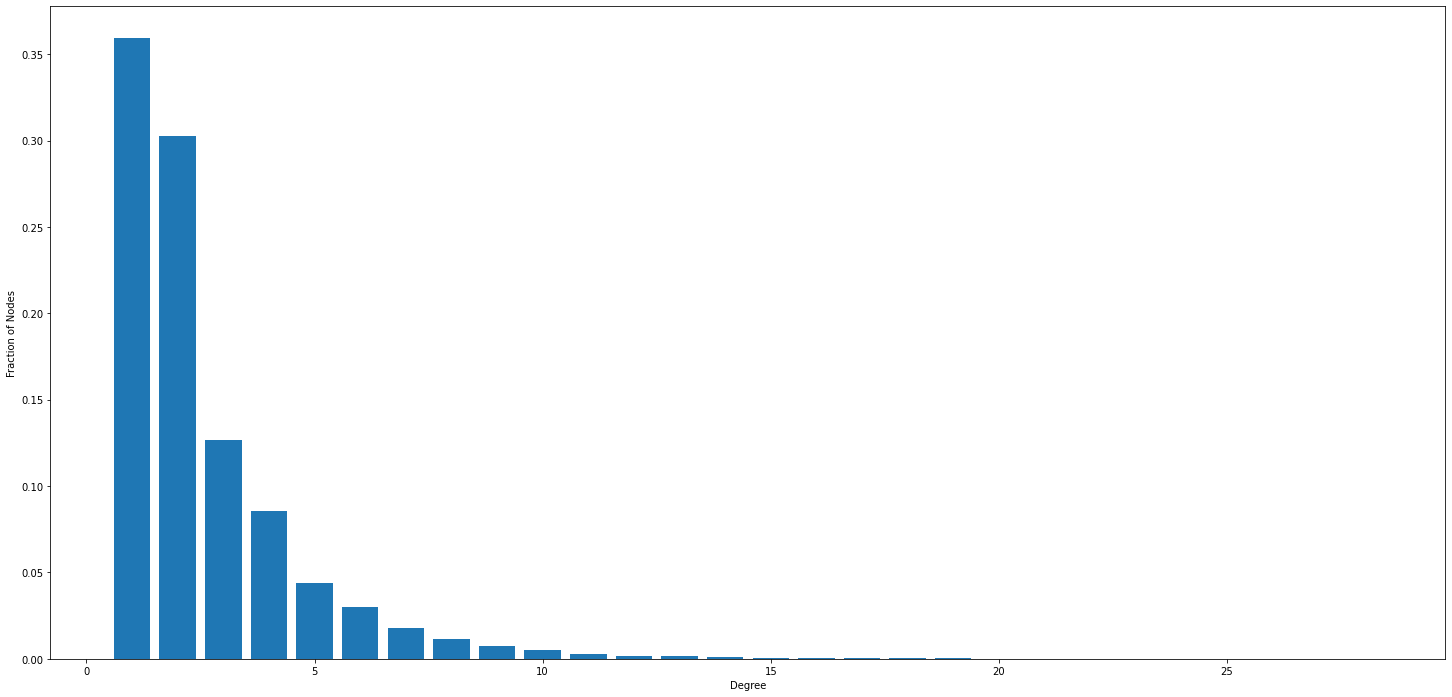

In [98]:
degrees = dict(G.degree())
degree_values = sorted(set(degrees.values()))
histogram = [list(degrees.values()).count(i)/float(nx.number_of_nodes(G)) for i in degree_values]

plt.bar(degree_values, histogram)
plt.xlabel('Degree')
plt.ylabel('Fraction of Nodes')
plt.show()